# Pollution estimation with improved accuracy using a combination of hyper-spectral satellite imagery data and maps

## Problem Statement

#### Using satellite imagery along with the map data from the open street map to find the regression estimate of pollution (Nitrogen Dioxide) in the region for specific time instances

### Approcah

In [ ]:
### 

In [230]:
## model 2 feature extraction
import numpy as np
import geopy.distance


In [ ]:
def extract(coordinates):
    latitude_1=50.0
    latitude_2=52
    longitude_1=-1
    longitude_2=2
    lat=float(coordinates.split(',')[0])
    lon=float(coordinates.split(',')[1])
    if lat > latitude_1 and lat < latitude_2 and lon > longitude_1 and lon < longitude_2:
        return str(lat)+','+str(lon)
    else:
        return 0
    

def get_span_grid(latitude,longitude):
    distance_between={}
    a=latitude
    b=longitude
    for i in coord_local.columns:
        for j in coord_local.index:
            coords_1=(a,b)
            try:
                coords_2=(float(coord_local[i][j].split(',')[0]),float(coord_local[i][j].split(',')[1]))
                dist_calc=geopy.distance.distance(coords_1, coords_2).km
                #print(dist_calc)
                distance_between[float(dist_calc)]=(i,j)
            except AttributeError:
                continue
    
    grid,span=distance_between[min(distance_between.keys())]
    return grid,span

def get_hyper_Spectral_features(lat,lon):
    ground_pixel,span_line=get_span_grid(lat,lon)
    feature1=air_mass_factor_troposphere.iloc[span_line][ground_pixel]
    feature2=cloud_radiance_fraction_nitrogendioxide_window.iloc[span_line][ground_pixel]
    feature3=nitrogendioxide_tropospheric_column.iloc[span_line][ground_pixel]
    feature4=water_liquid_slant_column_density.iloc[span_line][ground_pixel]
    hyper_spectral_features=[feature1,feature2,feature3,feature4]
    return hyper_spectral_features

In [228]:
coord=pd.read_csv('data1/geographical_data/coord.csv')

coord_local=coord.copy()
for i in coord_local.columns.tolist():
    coord_local[i]=coord_local[i].apply(lambda x: extract(x))
    
coord_local=coord_local.loc[~(coord_local==0).all(axis=1)]
coord_local=coord_local.loc[~(coord_local==0).all(axis=1)]

list_drop=[]

for i in coord_local.columns:
    #coord_local[i]=coord_local[i].apply(lambda x:float(x))
    try:
        coord_local[i]=coord_local[i].apply(lambda x:float(x))
        
    except ValueError:
        continue
    try:
        if coord_local[i].sum()==0:
            list_drop.append(i)
    except TypeError:
        continue
coord_local=coord_local.drop(list_drop, axis=1)

air_mass_factor_troposphere=pd.read_csv('data1/features/air_mass_factor_troposphere.csv')
cloud_radiance_fraction_nitrogendioxide_window=pd.read_csv('data1/features/cloud_radiance_fraction_nitrogendioxide_window.csv')
nitrogendioxide_tropospheric_column=pd.read_csv('data1/features/nitrogendioxide_tropospheric_column.csv')
water_liquid_slant_column_density=pd.read_csv('data1/features/water_liquid_slant_column_density.csv')


# Training dataset

In [19]:
import smopy
import cv2
lat=51.20
lon=-0.25
LatMin=lat-0.1
LatMax=lat+0.1
LngMin=lon-0.1
LngMax=lon+0.1

#Map with labels
map = smopy.Map((LatMin,LngMin, LatMax,LngMax))
#map.save_png('London.png')
#map.show_ipython()
gray=0
#Map without labels (if needed)
#map = smopy.Map((LatMin,LngMin, LatMax,LngMax), tileserver="https://tiles.wmflabs.org/osm-no-labels/{z}/{x}/{y}.png")#,tilesize=512,maxtiles=9)
name=str(lat)+'_'+str(lon)+'.png'
map.save_png(name)
#map.show_ipython()
#type(map)
img = cv2.imread(name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
scale_percent = 8 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

Lowered zoom level to keep map size reasonable. (z = 11)


In [22]:
resized_image = cv2.resize(img, (60, 60)) 
resized_image.shape
map = smopy.Map((LatMin,LngMin, LatMax,LngMax))
name=str(lat)+'_'+str(lon)+'.png'
map.save_png(name)
img = cv2.imread(name)

(60, 60, 3)

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [31]:

from tensorflow.keras import datasets, layers, models
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))


In [39]:
#model1
from tensorflow.keras.layers import Dense, Dropout, Input,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
input1=Input(shape=(60, 60, 3))
y1=Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3))(input1)
y2= MaxPooling2D()(y1)
y3=Conv2D(64, (3, 3), activation='relu')(y2)
y4= Flatten()(y3)
output1=Dense(10, activation="relu")(y4)

In [37]:
#model2
input2=Input(shape=(168,))
z1=Dense(5, activation="relu")(input2)
#model3
input3=Input(shape=(4,))
x=Dense(1, activation="relu")(input3)

In [42]:
merge = concatenate([output1, z1,x])
out=Dense(1, activation="relu")(merge)

In [ ]:
model=Model(inputs=[input1,input2,input3],outputs=[out])
model.compile(optimizer='adam', loss='mean_absolute_error')

In [44]:
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [30]:
img_inputs = tf.keras.Input(shape=(32, 32, 3))
y1=Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3))(img_inputs)
y2=layers.MaxPooling2D((2, 2))(y1)
y3=layers.Conv2D(64, (3, 3), activation='relu')
y4=layers.Flatten()(y3)
y5=layers.Dense(64, activation='relu')(y4)

inputs_timeseries = keras.Input(shape=(168,))
y_dense1 = layers.Dense(5, activation="relu")

inputs_hyper = keras.Input(shape=(4,))
y_dense2 = layers.Dense(1, activation="relu")

merged = Concatenate([y5, y_dense1,y_dense2])

The following Variables were used a Lambda layer's call (tf.nn.convolution_2), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_6/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_6/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


TypeError: Inputs to a layer should be tensors. Got: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000027CFFB5DE50>

In [18]:
cv2.imshow('rrt ',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

(230, 230)

In [13]:
gray
import numpy as np
features = np.reshape(gray, (gray.shape[0]*gray.shape[1])) 
features.shape

(52900,)

In [4]:
img = cv2.imread(name)
type(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
scale_percent = 30 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

NameError: name 'cv2' is not defined

In [14]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [15]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [450]:
scale_percent = 50 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [451]:
resized.shape

(384, 384, 3)

In [454]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

In [1]:
gray.shape

NameError: name 'gray' is not defined

In [ ]:
cv2.imshow('rrt ',gray)
#cv2.waitKey(0)

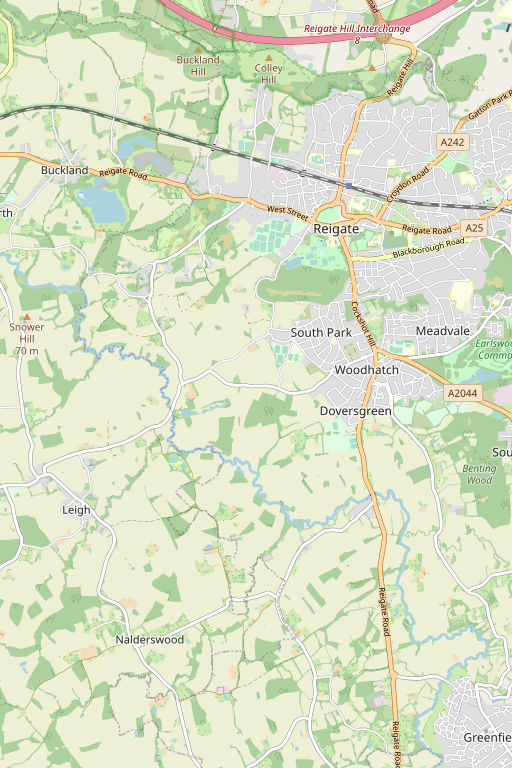

In [430]:
x, y = map.to_pixels(51.5072, -0.1276)
#ax = map.show_mpl(figsize=(8, 8))
#ax.plot(x, y, 'or', ms=10, mew=2)
t=(map.show_ipython()

In [432]:
t

array(None, dtype=object)

# Break

In [ ]:


for i in coord.columns.tolist():
    latitude[i]=latitude[i].apply(lambda x: 0 if x < latitude_1 else x )
    latitude[i]=latitude[i].apply(lambda x: 0 if x > latitude_2 else x )
    #latitude[i]=latitude[i].apply(lambda x: x if x > latitude_1 and x < latitude_2  else 0 )

In [159]:
for i in longitude.columns.tolist():
    longitude[i]=longitude[i].apply(lambda x: 0 if x < longitude_1 else x )
    longitude[i]=longitude[i].apply(lambda x: 0 if x > longitude_2 else x )
    

In [85]:
spanline=[]
grid=[]
lat=[]
lon=[]
lat_lon=[]
for i in latitude.columns:
    for j in list(latitude.index):
        if latitude.iloc[j][i] != 0:
            m=m+1
            lat.append(latitude.iloc[j][i])
            lon.append(longitude.iloc[j][i])
            lat_lon.append(str(latitude.iloc[j][i])+','+longitude.iloc[j][i])
        

In [86]:
search_df=pd.DataFrame(list(zip(spanline,grid,lat,lon,lat_lon)),columns=['spanline', 'grid', 'lat','lon','lat_lon'])

In [178]:
latitude_trial=latitude.reset_index()

In [180]:
latitude_trial=latitude.copy()

In [181]:
latitude_trial

,1,2,3,4,5,6,7,8,9,10,...,441,442,443,444,445,446,447,448,449,450
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
latitude_trial=latitude_trial.loc[~(latitude_trial==0).all(axis=1)]
df=latitude.copy()

In [185]:
df = df.loc[(df).any(1), (df!=0).any(0)]

In [187]:
df = df[(df.T != 0).any()]

In [163]:
for i in latitude_trial.columns:
    latitude_trial=latitude_trial[latitude_trial[i] != 0]

In [164]:
latitude_trial

,index,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,450


In [123]:
latitude_trial=latitude_trial.replace(0,np.nan).dropna(axis=1,how="all")
latitude_trial


,1,2,3,4,5,6,7,8,9,10,...,441,442,443,444,445,446,447,448,449,450
1927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.994721,-0.988281,-0.981761,-0.975161,-0.968477,-0.961708,-0.954849
1928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.965192,-0.958987,-0.952710,-0.946359,-0.939932,-0.933426,-0.926840,-0.920170,-0.913415,-0.906571
1929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.916801,-0.910608,-0.904344,-0.898007,-0.891593,-0.885101,-0.878529,-0.871873,-0.865132,-0.858304
1930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.868423,-0.862243,-0.855992,-0.849668,-0.843267,-0.836789,-0.830231,-0.823590,-0.816864,-0.810050
1931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.820085,-0.813918,-0.807681,-0.801369,-0.794983,-0.788519,-0.781974,-0.775348,-0.768636,-0.761837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,49.790680,49.845790,49.900055,49.953495,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3125,49.833220,49.888374,49.942684,49.996166,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3126,49.875725,49.930923,49.985270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3127,49.918350,49.973587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
coord=pd.read_csv('data1/25_03_2021/coord.csv')
def extract(coordinates):
    latitude_1=50.0
    latitude_2=52
    longitude_1=-1
    longitude_2=2
    lat=float(coordinates.split(',')[0])
    lon=float(coordinates.split(',')[1])
    if lat > latitude_1 and lat < latitude_2 and lon > longitude_1 and lon < longitude_2:
        return str(lat)+','+str(lon)
    else:
        return 0

coord_local=coord.copy()
for i in coord_local.columns.tolist():
    coord_local[i]=coord_local[i].apply(lambda x: extract(x))
	
coord_local=coord_local.loc[~(coord_local==0).all(axis=1)]
#coord_local

coord_local=coord_local.loc[~(coord_local==0).all(axis=1)]

list_drop=[]
'''
if coord_local[i].sum()==0:
            list_drop.append(i)
'''
for i in coord_local.columns:
    #coord_local[i]=coord_local[i].apply(lambda x:float(x))
    try:
        coord_local[i]=coord_local[i].apply(lambda x:float(x))
        
    except ValueError:
        continue
    try:
        if coord_local[i].sum()==0:
            list_drop.append(i)
    except TypeError:
        continue


coord_local=coord_local.drop(list_drop, axis=1)
import geopy.distance


In [ ]:
df[df.my_channel > 20000].my_channel = 0

In [61]:
latitude

,1,2,3,4,5,6,7,8,9,10,...,441,442,443,444,445,446,447,448,449,450
0,-80.200420,-80.245056,-80.288475,-80.330710,-80.371796,-80.411766,-80.450645,-80.488464,-80.525250,-80.561035,...,-67.670870,-67.596790,-67.521750,-67.445740,-67.368720,-67.290670,-67.211570,-67.131390,-67.050095,-66.967650
1,-80.244020,-80.288820,-80.332390,-80.374780,-80.416016,-80.456130,-80.495155,-80.533110,-80.570040,-80.605950,...,-67.691140,-67.617010,-67.541940,-67.465880,-67.388820,-67.310730,-67.231580,-67.151350,-67.070015,-66.987526
2,-80.287530,-80.332480,-80.376220,-80.418760,-80.460150,-80.500410,-80.539580,-80.577680,-80.614746,-80.650795,...,-67.711400,-67.637230,-67.562110,-67.486015,-67.408910,-67.330780,-67.251595,-67.171320,-67.089935,-67.007410
3,-80.331154,-80.376274,-80.420166,-80.462860,-80.504400,-80.544810,-80.584120,-80.622360,-80.659560,-80.695740,...,-67.731450,-67.657250,-67.582085,-67.505940,-67.428795,-67.350620,-67.271385,-67.191070,-67.109640,-67.027070
4,-80.374750,-80.420030,-80.464080,-80.506935,-80.548620,-80.589180,-80.628640,-80.667015,-80.704350,-80.740670,...,-67.751380,-67.677124,-67.601920,-67.525734,-67.448550,-67.370320,-67.291050,-67.210686,-67.129210,-67.046590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3730,68.534836,68.620540,68.705055,68.788420,68.870674,68.951830,69.031920,69.110980,69.189026,69.266090,...,86.038930,85.984080,85.927900,85.870410,85.811560,85.751366,85.689800,85.626830,85.562460,85.496660
3731,68.546640,68.632340,68.716866,68.800230,68.882484,68.963640,69.043740,69.122795,69.200840,69.277910,...,86.073074,86.017780,85.961174,85.903244,85.843970,85.783350,85.721350,85.657970,85.593180,85.526955
3732,68.558365,68.644070,68.728600,68.811966,68.894220,68.975380,69.055470,69.134540,69.212585,69.289650,...,86.106890,86.051155,85.994120,85.935750,85.876045,85.814995,85.752570,85.688760,85.623550,85.556915
3733,68.570100,68.655800,68.740326,68.823690,68.905945,68.987110,69.067200,69.146260,69.224310,69.301380,...,86.140360,86.084180,86.026695,85.967896,85.907760,85.846270,85.783420,85.719185,85.653550,85.586490


In [ ]:
#model training
#given time location
fatures1=get_hyperstructure
features_2=get_map
features=[1pm 2pm 3pm 4pm ]
output=no2 at given time

In [275]:
#Time series
London_Bexley=(51.462900, 0.139400)
df=pd.read_csv('data1/timeseries/51.462900_ 0.139400.csv')

In [276]:
df=df.dropna()

In [277]:
df['date']=df['Date']+' '+df['Time']

In [278]:
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

In [84]:
def convert_date(date_string):
    convert_date=datetime.strptime(date_string, '%B %d %Y %H:%M%p')
    convert_date=convert_date.strftime('%d/%m/%Y %H:%M:%S')
    convert_date=datetime.strptime(convert_date, '%d/%m/%Y %H:%M:%S')
    return convert_date

In [279]:
#given_date=%B %d %Y %H:%M%p
given_date='March 25 2021 11:00AM'
convert_date=datetime.strptime(given_date, '%B %d %Y %H:%M%p')
convert_date=convert_date.strftime('%d/%m/%Y %H:%M:%S')

In [271]:
convert_date

'25/03/2021 11:00:00'

In [289]:
#given coordinates and date and time, extract time series and dependent variable
import os
arr = os.listdir('data1/timeseries')

In [290]:

arr

['51.462900_0.139400.csv',
 '51.522918_-0.130821.csv',
 '51.526213_-0.461329.csv']

In [306]:
import geopy.distance
lat_1=51.522918

lon_1=-0.130821
coord_1=(lat_1,lon_1)
#distgeopy.distance.distance(coords_1, coords_2).km

dist=10000
for i in arr:
    coord_2=(float(i.split('_')[0]),i.split('_')[1].split('.csv')[0])
    #print(coord_2)
    distance=geopy.distance.distance(coord_1, coord_2).km
    #print(distance)
    if distance <dist:
        dist=distance
        coord_pointer=i


In [307]:
coord_pointer

'51.522918_-0.130821.csv'

In [313]:
df =pd.read_csv('data1/timeseries/'+coord_pointer)
df=df.dropna()
df['date']=df['Date']+' '+df['Time']
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

In [347]:
given_time= 'March 26 2021 11:00AM'
time=convert_date(given_time)

In [330]:
y= float(df[df.date == time]['Nitrogen dioxide'])

In [350]:
hours = 168
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
hours_added = timedelta(hours = -hours)
time_past=time + hours_added
#future_date_and_time = current_date_and_time + hours_added
time_past

datetime.datetime(2021, 3, 19, 11, 0)

In [385]:
#df['Nitrogen dioxide']=df['Nitrogen dioxide'].apply(lambda x: str(x))
#df['Nitrogen dioxide']=df['Nitrogen dioxide'].apply(lambda x: float(x))
import statistics

x= df[df['date'] < time]#['Nitrogen dioxide']
x=x[x['date'] >= time_past]['Nitrogen dioxide']
#x=x.apply(lambda y:float(y))
x=list(x)
X=[]
for i in x:
    try:
        X.append(float(i))
    except ValueError:
        X.append(statistics.mean(X))

In [ ]:
#TRaining time series

In [121]:
import pandas as pd
df =pd.read_csv('data1/timeseries/'+'51.522918_-0.130821.csv')
df=df.dropna()
df['date']=df['Date']+' '+df['Time']
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

In [122]:
time_ran=['AM','PM']
month_ran=['March','April']
day_ran=list(range(8,30))
time1_ran=list(range(1,12))


In [123]:
import random
import statistics
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
given_time= random.choice(month_ran)+ ' '  + str(random.choice(day_ran))+ ' ' + '2021' + ' ' + str(random.choice(time1_ran)) +':'+'00'+random.choice(time_ran)

In [143]:
import pandas as pd
df =pd.read_csv('data1/timeseries/'+'51.462900_0.139400.csv')
df=df.dropna()
df['date']=df['Date']+' '+df['Time']
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
import smopy
import cv2

lat=51.462900
lon=0.139400
LatMin=lat-0.1
LatMax=lat+0.1
LngMin=lon-0.1
LngMax=lon+0.1
map = smopy.Map((LatMin,LngMin, LatMax,LngMax))
name=str(lat)+'_'+str(lon)+'.png'
map.save_png(name)
img = cv2.imread(name)
resized_image = cv2.resize(img, (60, 60)) 
resized_image.shape


Lowered zoom level to keep map size reasonable. (z = 12)


(60, 60, 3)

In [144]:

def get_span_grid(latitude,longitude):
    distance_between={}
    a=latitude
    b=longitude
    for i in coord_local.columns:
        for j in coord_local.index:
            coords_1=(a,b)
            try:
                coords_2=(float(coord_local[i][j].split(',')[0]),float(coord_local[i][j].split(',')[1]))
                dist_calc=geopy.distance.distance(coords_1, coords_2).km
                #print(dist_calc)
                distance_between[float(dist_calc)]=(i,j)
            except AttributeError:
                continue
    
    grid,span=distance_between[min(distance_between.keys())]
    return grid,span
def get_hyper_Spectral_features(lat,lon):
    ground_pixel,span_line=get_span_grid(lat,lon)
    feature1=air_mass_factor_troposphere.iloc[span_line][ground_pixel]
    feature2=cloud_radiance_fraction_nitrogendioxide_window.iloc[span_line][ground_pixel]
    feature3=nitrogendioxide_tropospheric_column.iloc[span_line][ground_pixel]
    feature4=water_liquid_slant_column_density.iloc[span_line][ground_pixel]
    hyper_spectral_features=[feature1,feature2,feature3,feature4]
    return hyper_spectral_features
spec_features=get_hyper_Spectral_features(lat,lon)
spec_features

[0.64097416, 0.6000305, 5.68e-05, -0.89386904]

In [145]:
#x_array=[]
#y_array=[]
#x_time=[]
#x_hyper=[]
#x_map=[]
for i in range(800):
    x_map.append(resized_image)
    x_hyper.append(spec_features)
    temp=0
    given_time= random.choice(month_ran)+ ' '  + str(random.choice(day_ran))+ ' ' + '2021' + ' ' + str(random.choice(time1_ran)) +':'+'00'+random.choice(time_ran)
    time=convert_date(given_time)
    try:
        y= float(df[df.date == time]['Nitrogen dioxide'])
    except ValueError:
        y =0
    
    hours = 168
    hours_added = timedelta(hours = -hours)
    time_past=time + hours_added
    #future_date_and_time = current_date_and_time + hours_added
    time_past
    x= df[df['date'] < time]#['Nitrogen dioxide']
    x=x[x['date'] >= time_past]['Nitrogen dioxide']
    x=list(x)
    X=[]
    for i in x:
        try:
            X.append(float(i))
        except ValueError:
            X.append(0)
            temp=X.copy()
    y_array.append(y)
    x_array.append(X)

In [148]:
len(x_time)

0

# Model Training

In [198]:
#model1
from tensorflow.keras.layers import Dense, Dropout, Input,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
#from keras.optimizers import SGD
from tensorflow.keras.models import Model
input1=Input(shape=(60, 60, 3))
y1=Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3))(input1)
y2= MaxPooling2D()(y1)
y3=Conv2D(64, (3, 3), activation='relu')(y2)
y4= Flatten()(y3)
output1=Dense(10, activation="relu")(y4)

#model2
input2=Input(shape=(168,))
z1=Dense(5, activation="relu")(input2)
#model3
input3=Input(shape=(4,))
x=Dense(1, activation="relu")(input3)

merge = concatenate([output1, z1,x])
out=Dense(1, activation="relu")(merge)

model=Model(inputs=[input1,input2,input3],outputs=[out])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_absolute_error')



In [158]:
x_array_np=np.array(x_array)
y_array_np=np.array(y_array)
x_hyper_np=np.array(x_hyper)
x_map_np=np.array(x_map)


In [160]:
x_array_np.shape

(2400, 168)

In [199]:
model.fit([x_map_np,x_array_np,x_hyper_np],y_array_np)

75/75 [==============================] - 10s 129ms/step - loss: 16.6681


In [164]:
tf.config.run_functions_eagerly(True)

In [169]:
f=np.array(np.array(x_map_np[0]),x_array_np[0],x_hyper_np[0])

TypeError: array() takes from 1 to 2 positional arguments but 3 were given

In [201]:
a=np.array(x_map[0:15])
b=np.array(x_array[0:15])
c=np.array(x_hyper[0:15])
#np.array(x_map[0]),np.array(x_array[0]),np.array(x_hyper[0])
c.shape

(15, 4)

In [206]:
a=np.array(x_map[15])
a_n=a[ np.newaxis, :]
a_n.shape

(1, 60, 60, 3)

In [202]:
g=model.predict([a,b,c])

In [227]:
coord_local.to_excel('get_geographical_data.xlsx')

# Model prediction

In [215]:
input_latitude=51.472830
input_longitude=-0.013733
input_time='March 11 2021 11:00AM'
hyper_spec_features=get_hyper_Spectral_features(input_latitude,input_longitude)
hyper_spec_features=np.array(hyper_spec_features)
hyper_spec_features=hyper_spec_features[ np.newaxis, :]

import pandas as pd


import geopy.distance
lat_1=51.522918

lon_1=-0.130821
coord_1=(lat_1,lon_1)
#distgeopy.distance.distance(coords_1, coords_2).km
def get_coord_pointer(lat,lon):
    coord_1=(lat,lon)
    array_coord = os.listdir('data1/timeseries')
    dist=10000
    for i in array_coord:
        coord_2=(float(i.split('_')[0]),i.split('_')[1].split('.csv')[0])
        distance=geopy.distance.distance(coord_1, coord_2).km
        if distance <dist:
            dist=distance
            coord_pointer=i
            
    return coord_pointer


df =pd.read_csv('data1/timeseries/'+get_coord_pointer(input_latitude,input_longitude))
df=df.dropna()
df['date']=df['Date']+' '+df['Time']
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

time=convert_date(input_time)

hours = 168
hours_added = timedelta(hours = -hours)
time_past=time + hours_added
time_past
x= df[df['date'] < time]#['Nitrogen dioxide']
x=x[x['date'] >= time_past]['Nitrogen dioxide']
x=list(x)
X=[]
for i in x:
    try:
        X.append(float(i))
    except ValueError:
         X.append(0)
time_features=X
time_features=np.array(time_features)
time_features=time_features[ np.newaxis, :]

LatMin=input_latitude-0.1
LatMax=input_latitude+0.1
LngMin=input_longitude-0.1
LngMax=input_longitude+0.1
map = smopy.Map((LatMin,LngMin, LatMax,LngMax))
name=str(input_latitude)+'_'+str(input_longitude)+'.png'
map.save_png(name)
img = cv2.imread(name)
resized_image = cv2.resize(img, (60, 60)) 
resized_image.shape

map_features=np.array(resized_image)
map_features=map_features[ np.newaxis, :]

prediction=model.predict([map_features,time_features,hyper_spec_features])
result=float(prediction)

Lowered zoom level to keep map size reasonable. (z = 11)


C:\Users\Hamzah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [ ]:
import pandas as pd
import geopy.distance


## Importanct functions

In [224]:
def get_coord_pointer(lat,lon):
    coord_1=(lat,lon)
    array_coord = os.listdir('data1/timeseries')
    dist=10000
    for i in array_coord:
        coord_2=(float(i.split('_')[0]),i.split('_')[1].split('.csv')[0])
        distance=geopy.distance.distance(coord_1, coord_2).km
        if distance <dist:
            dist=distance
            coord_pointer=i
            
    return coord_pointe


model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


# Predictiion

### Input formats in model

- Input latitude in float format
- Input longitude in float format
- Input time in following format '21 March 2021 12:00AM'



### prediction=predict_NO2(latitude,longitude,time)
## Example
`prediction=predict_NO2(51.472830, -0.013733,'March 21 2021 12:00AM')`

#### Note: Enter date between 9th March 2021 to 30th April 2022 (due to limitation of data given in challenge). It takes last 7 days data as time series input

### Load model weight

In [221]:
def predict_NO2(input_latitude,input_longitude,input_time):
    hyper_spec_features=get_hyper_Spectral_features(input_latitude,input_longitude)
    hyper_spec_features=np.array(hyper_spec_features)
    hyper_spec_features=hyper_spec_features[ np.newaxis, :]

    df =pd.read_csv('data1/timeseries/'+get_coord_pointer(input_latitude,input_longitude))
    df=df.dropna()
    df['date']=df['Date']+' '+df['Time']
    from datetime import datetime
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

    time=convert_date(input_time)

    hours = 168
    hours_added = timedelta(hours = -hours)
    time_past=time + hours_added
    time_past
    x= df[df['date'] < time]#['Nitrogen dioxide']
    x=x[x['date'] >= time_past]['Nitrogen dioxide']
    x=list(x)
    X=[]
    for i in x:
        try:
            X.append(float(i))
        except ValueError:
             X.append(0)
    time_features=X
    time_features=np.array(time_features)
    time_features=time_features[ np.newaxis, :]

    LatMin=input_latitude-0.1
    LatMax=input_latitude+0.1
    LngMin=input_longitude-0.1
    LngMax=input_longitude+0.1
    map = smopy.Map((LatMin,LngMin, LatMax,LngMax))
    name=str(input_latitude)+'_'+str(input_longitude)+'.png'
    map.save_png(name)
    img = cv2.imread(name)
    resized_image = cv2.resize(img, (60, 60)) 
    resized_image.shape

    map_features=np.array(resized_image)
    map_features=map_features[ np.newaxis, :]

    prediction=model.predict([map_features,time_features,hyper_spec_features])
    result=float(prediction)
    return result

In [223]:
prediction=predict_NO2(51.472830, -0.013733,'March 21 2021 12:00AM')

Lowered zoom level to keep map size reasonable. (z = 11)


C:\Users\Hamzah\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


### Load model from saved folder

23.333389282226562

In [ ]:
def predict